In [1]:
import os
import glob
import cv2

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Find HOG features in a image
    """
    if not vis:
        features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=True, 
                           visualise=vis, feature_vector=feature_vec)
        return features

    features, hog_image = hog(img, orientations=orient, 
                              pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=True, 
                              visualise=vis, feature_vector=feature_vec)
    return features, hog_image

 
def bin_spatial(img, size=(16, 16)):
    """
    Compute binned color features
    """
    return cv2.resize(img, size).ravel() 


def color_hist(img, nbins=32):
    """
    Compute color histogram features 
    """
    c1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]
    c2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    c3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((c1, c2, c3))
    return hist

In [2]:
def extract_feature(img, color_space='RGB', spatial_size=(32, 32),
                    hist_bins=32, orient=9,pix_per_cell=8,cell_per_block=2, 
                    hog_channel=0,spatial_feat=True, hist_feat=True, hog_feat=True):    

    img_features = []

    if color_space == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: 
        feature_image = np.copy(image)     

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)

    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)

    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        img_features.append(hog_features)
    return np.concatenate(img_features)

def extract_features_from_files(img_files, color_space='RGB', spatial_size=(32, 32),hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in img_files:
        feas = []
        image = cv2.imread(file) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        feas = extract_feature(image,color_space,spatial_size,
                                hist_bins, orient, pix_per_cell, cell_per_block,
                                hog_channel, spatial_feat,hist_feat, hog_feat)
        features.append(feas)
        
        image=cv2.flip(image,1) 
        feas = extract_feature(image,color_space,spatial_size,
                                hist_bins, orient, pix_per_cell, cell_per_block,
                                hog_channel, spatial_feat,hist_feat, hog_feat)
        features.append(feas)
        
    return features 

In [5]:
cars = glob.iglob('data/vehicles/**/*.png')
notcars = glob.iglob('data/non-vehicles/**/*.png')

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


print("Extracting car_features")
car_features = extract_features_from_files(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print("Extracting notcar_features")
notcar_features = extract_features_from_files(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) 
scaled_X = X_scaler.transform(X) 

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)))) 


X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

print('Feature :', len(X_train[0]))
svc = LinearSVC(loss='hinge') 

svc.fit(X_train, y_train) 
print('Test Accuracy ', round(svc.score(X_test, y_test), 4)) 

Extracting car_features


/home/mma/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Extracting notcar_features
Feature : 6108
Test Accuracy  0.9913


In [35]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))

    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    img_new = np.copy(img) 
    for bbox in bboxes: 
        cv2.rectangle(img_new, bbox[0], bbox[1], color, thick)
    return img_new

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True, debug = False):

    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = extract_feature(test_img, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        confidence = clf.decision_function(test_features)
        if confidence >= 1.0:
            on_windows.append(window)
            if debug : print("Classifier confidence: ", confidence)
    #8) Return windows for positive detections
    return on_windows

def show_image(img):
    img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show)
    plt.show()

In [29]:
images = []
for file in glob.glob('test_images/test*.jpg'):
    image = cv2.imread(file)
    images.append(image)

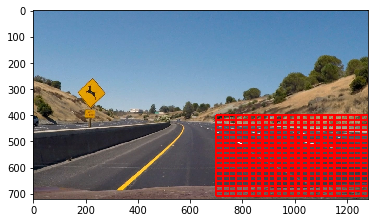

In [22]:
windows1 = slide_window(images[0], x_start_stop=[700, None], y_start_stop=[400, None], 
                xy_window=(128, 100), xy_overlap=(0.8, 0.8))
window_img = draw_boxes(image, windows1, color=(0, 0, 255), thick=6) 
show_image(window_img)

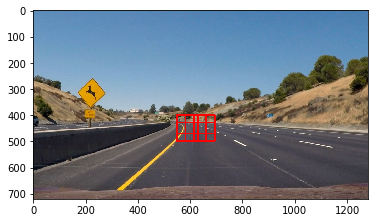

In [23]:
windows2 = slide_window(images[0], x_start_stop=[550, 700], y_start_stop=[400, 500], 
                xy_window=(80, 70), xy_overlap=(0.6, 0.6))
window_img = draw_boxes(image, windows2, color=(0, 0, 255), thick=6) 
show_image(window_img)

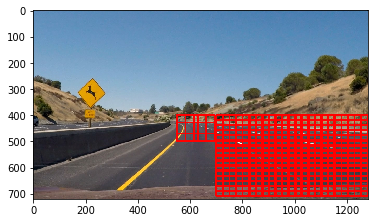

In [24]:
windows = windows1+windows2
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
show_image(window_img)

Classifier confidence:  [ 1.46393979]


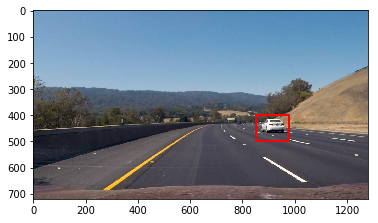

Classifier confidence:  [ 3.39583962]
Classifier confidence:  [ 1.95032457]
Classifier confidence:  [ 1.83038899]


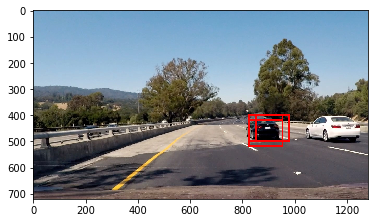

Classifier confidence:  [ 3.51361342]
Classifier confidence:  [ 2.06818709]
Classifier confidence:  [ 1.35513346]
Classifier confidence:  [ 1.25043852]
Classifier confidence:  [ 2.94229083]
Classifier confidence:  [ 1.78470374]
Classifier confidence:  [ 1.0677889]


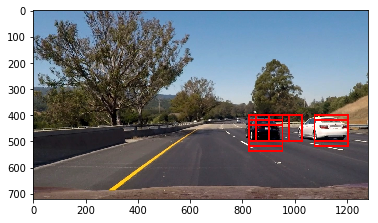

Classifier confidence:  [ 3.45054301]
Classifier confidence:  [ 1.15980479]


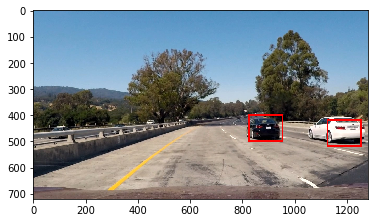

Classifier confidence:  [ 1.57014474]
Classifier confidence:  [ 3.26113897]
Classifier confidence:  [ 4.09679295]
Classifier confidence:  [ 1.51294642]
Classifier confidence:  [ 1.61288041]
Classifier confidence:  [ 1.63956082]
Classifier confidence:  [ 2.19117153]
Classifier confidence:  [ 1.17303687]
Classifier confidence:  [ 1.17625434]
Classifier confidence:  [ 2.12125833]


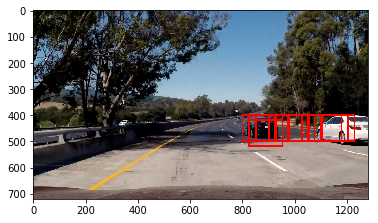

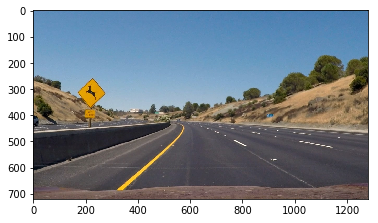

In [36]:
for image in images:
    image_test = cv2.GaussianBlur(image, (15, 15), 0)
    draw_image = np.copy(image)
    hot_windows = []
    hot_windows += (search_windows(image_test, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,debug=True))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)    
    show_image(window_img)

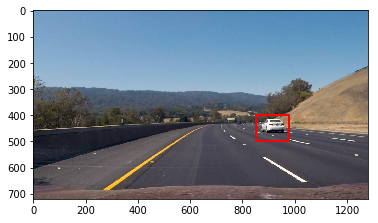

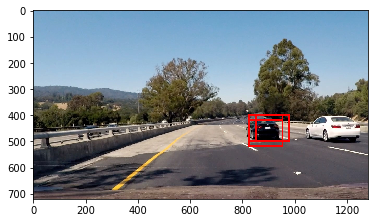

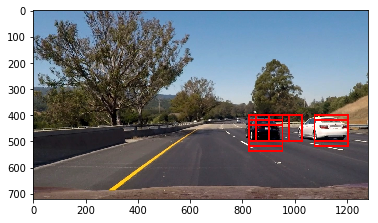

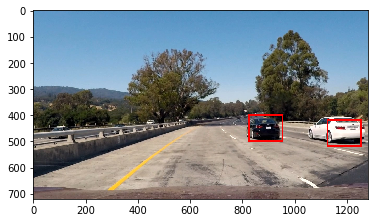

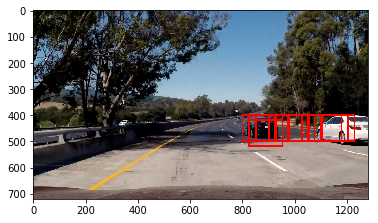

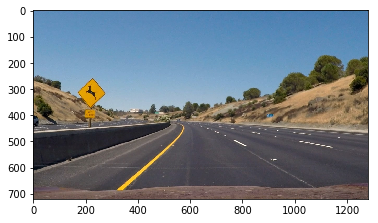

In [34]:
for image in images:
    image_test = cv2.GaussianBlur(image, (15, 15), 0)
    draw_image = np.copy(image)
    hot_windows = []
    hot_windows += (search_windows(image_test, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)    
    show_image(window_img)

In [19]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)

    return img
    
from scipy.ndimage.measurements import label

def find_cars(input_image, windows, classifier, scaler, draw=True):
    global bboxes_list
    
    hot_windows = search_windows(input_image, windows, classifier, scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    bboxes_list.append(hot_windows)
#     if draw == True:
#         draw_image = np.copy(input_image)
#         window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=5)
#         return window_img
    
def add_bboxes_to_list(image):
    return add_bboxes(image, windows, svc, X_scaler)


def add_heat(heatmap, box_list):
    for box in box_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def create_heatmaps(all_bboxes, recent_frames_used=20, threshold=5):
    heatmap_list = []

    for idx, boxlist in enumerate(all_bboxes):
        idx_start = max(idx - recent_frames_used, 0)
        idx_heatmap = heatmap_template
        for boxlist2 in all_bboxes[idx_start:idx + 1]:
            idx_heatmap = add_heat(idx_heatmap, boxlist2)

        idx_heatmap[idx_heatmap <= threshold] = 0
        heatmap_list.append(idx_heatmap)
        plt.imshow(idx_heatmap, cmap="hot")

    return heatmap_list

def pipeline(image):
    global bboxes_list
    global heat_map_g
    recent_frames_used=15
    threshold=10
    
    image_test = cv2.GaussianBlur(image, (15, 15), 0)
    find_cars(image_test, windows, svc, X_scaler, draw=False)
    
    # Adjust parameters if needed
    if len(bboxes_list) < recent_frames_used + 1:
        recent_frames_used = len(bboxes_list) - 1    
    
    frame_heatmap = np.zeros_like(image[:,:,0])
    for boxlist in bboxes_list[-recent_frames_used:]:
        frame_heatmap = add_heat(frame_heatmap, boxlist)
    
    heat_map_g = frame_heatmap.copy()
    # Apply threshold
    frame_heatmap[frame_heatmap <= threshold] = 0
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.imshow(draw_img)
    return draw_img

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:46<00:01,  1.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 46.5 s, sys: 129 ms, total: 46.6 s
Wall time: 47.4 s


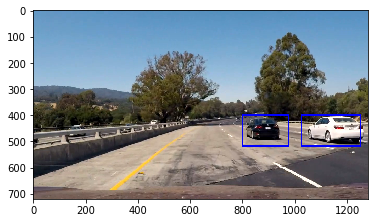

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = []
heat_map_g = None
video = VideoFileClip("test_video.mp4")
project_clip = video.fl_image(pipeline)
video_output = "test_video_output.mp4"
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video no_cars.mp4
[MoviePy] Writing video no_cars.mp4


 99%|█████████▉| 100/101 [00:50<00:00,  1.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: no_cars.mp4 

CPU times: user 50.1 s, sys: 212 ms, total: 50.3 s
Wall time: 51 s


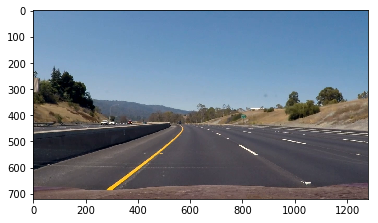

In [85]:
"""
Test case - No cars
"""
from moviepy.editor import VideoFileClip
# Clear the global variable first
bboxes_list = []
output = 'no_cars.mp4'
video = VideoFileClip("project_video.mp4").subclip(0,4)
processed_video = video.fl_image(pipeline)
%time processed_video.write_videofile(output, audio=False)

[MoviePy] >>>> Building video car_enters_from_right.mp4
[MoviePy] Writing video car_enters_from_right.mp4



 99%|█████████▉| 125/126 [00:30<00:00,  3.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: car_enters_from_right.mp4 

CPU times: user 30.5 s, sys: 412 ms, total: 30.9 s
Wall time: 31.5 s


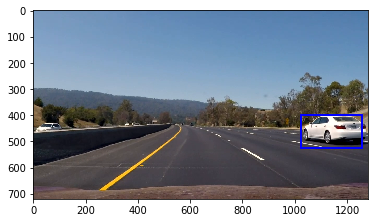

In [41]:
"""
Test case - Car enters from right
"""
# Clear the global variable first
bboxes_list = []
output = 'car_enters_from_right.mp4'
video = VideoFileClip("project_video.mp4").subclip(5,10)
processed_video = video.fl_image(pipeline)
%time processed_video.write_videofile(output, audio=False)

[MoviePy] >>>> Building video car_enters_from_right.mp4
[MoviePy] Writing video car_enters_from_right.mp4


 99%|█████████▉| 125/126 [01:22<00:00,  1.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: car_enters_from_right.mp4 

CPU times: user 1min 19s, sys: 532 ms, total: 1min 20s
Wall time: 1min 23s


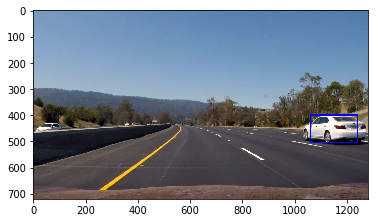

In [93]:
"""
Test case - Car enters from right
"""
# Clear the global variable first
bboxes_list = []
output = 'car_enters_from_right.mp4'
video = VideoFileClip("project_video.mp4").subclip(5,10)
processed_video = video.fl_image(pipeline)
%time processed_video.write_videofile(output, audio=False)

[MoviePy] >>>> Building video car_enters_from_right1.mp4
[MoviePy] Writing video car_enters_from_right1.mp4


 99%|█████████▉| 125/126 [01:11<00:00,  1.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: car_enters_from_right1.mp4 

CPU times: user 1min 10s, sys: 652 ms, total: 1min 10s
Wall time: 1min 12s


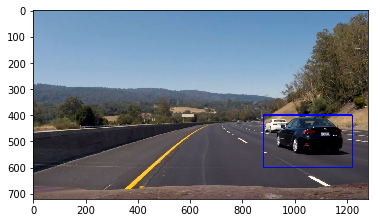

In [94]:
"""
Test case - Car enters from right
"""
# Clear the global variable first
bboxes_list = []
output = 'car_enters_from_right1.mp4'
video = VideoFileClip("project_video.mp4").subclip(26,31)
processed_video = video.fl_image(pipeline)
%time processed_video.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [26:08<00:01,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 25min 59s, sys: 7.26 s, total: 26min 6s
Wall time: 26min 9s


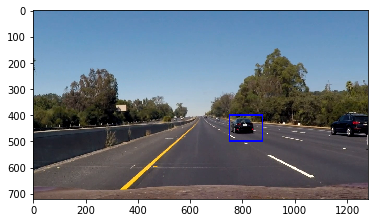

In [27]:
# Clear the global variable first
bboxes_list = []
output = 'project_video_output.mp4'
video = VideoFileClip("project_video.mp4")
processed_video = video.fl_image(pipeline)
%time processed_video.write_videofile(output, audio=False)